# **Character Level LSTM in PyTorch**





In this notebook, I'll construct a character-level LSTM with PyTorch. The network will train character by character on some text, then generate new text character by character. As an example, I will train on Anna Karenina. *This model will be able to generate new text based on text from the book!*


This network is based off of Andrew Karpathy's post on RNN https://karpathy.github.io/2015/05/21/rnn-effectiveness/
and implementation in Torch https://github.com/karpathy/char-rnn .



Below is the general architecture of the character-wise RNN.



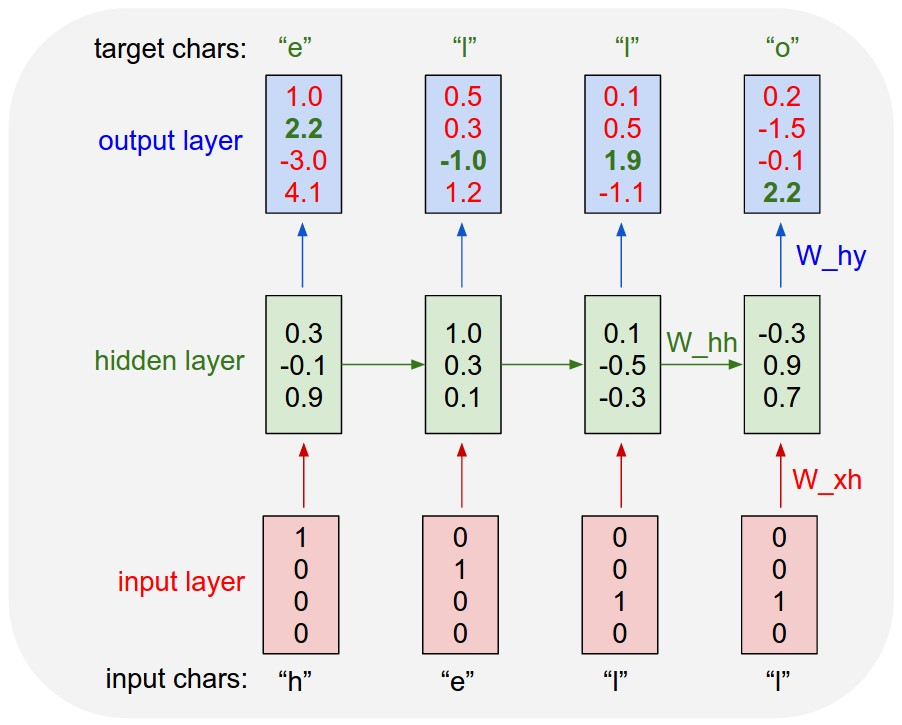


First let's load in our required for data loading and model creation.




In [2]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F

**Load in Data**

Then, we'll load the Anna Karenina text file and convert it to integers for our network to use.

Here's the link to download a text :
https://archive.org/stream/annakareninatols00tolsiala/annakareninatols00tolsiala_djvu.txt

In [3]:
# Open text file and read in data as 'text'

with open('annakareninanovel .txt', 'r') as f:
  text = f.read()

In [ ]:
text[:400]

"\nINTRODUCTION \n\n\nALEXANDER  PUSHKIN,  Russia's  greatest  poet \nand  the  inspirer  of  the  two  best  works  of  Gogol, \nthe  father  of  Russian  realism,  may  perhaps  be  regarded \nas  the  direct  cause  of  Count  Tolstoi's  greatest  novel. \nA  relative  happened  to  be  visiting  at  Yasnaya  Polyana, \nand  had  been  reading  a  volume  of  Pushkin.  Count \nTolstoi  picked  up  the  wo"

**Tokenization**


In the cells, below, I'm creating a couple *dictionaries* to convert the characters to and from integers.Encoding the characters as integers makes it easier to use as input in the network.

In [4]:
import numpy as np

# Encode the text and map each character to an integer and vice versa

# We create two dictionaries:
# 1. int2char, which maps integers to characters
# 2. char2int, which maps characters to unique integers

chars = tuple(set(text))
int2char = dict(enumerate(chars))
char2int = {ch: ii for ii, ch in int2char.items()}

# Encode the text
encoded = np.array([char2int[ch] for ch in text])

# And we can see those same characters from above, encoded as integers.

In [5]:
encoded[:100]

array([19, 14, 74, 10, 37, 91, 96, 28,  4, 10, 14, 91, 74, 84, 19, 19, 19,
       77, 53, 83, 92, 77, 74, 96, 83, 37, 84, 84, 18, 28, 60, 81, 55, 14,
       74, 25, 84, 84, 37, 35, 82, 82, 62, 99, 57, 82, 84, 84, 42, 64, 40,
       99, 36, 40, 82, 36, 84, 84, 80, 46, 40, 36, 84, 19, 99, 85, 95, 84,
       84, 36, 24, 40, 84, 84, 62, 85, 82, 80, 62, 64, 40, 64, 84, 84, 46,
       38, 84, 84, 36, 24, 40, 84, 84, 36, 13, 46, 84, 84, 39, 40])

**Pre-Processing the data**


As you can see in our char-RNN above image, our LSTM expects an input that is *one-hot-encoded* meaning that each character is converted into an integer (via our created dictionary) and then converted into a column vector where only it's corresponding
integer index will,have the value of 1 and the rest of the vector will be filled with 0's. Since we're one-hot encoding the data. let's make a function to do that!


In [6]:
def one_hot_encode(arr, n_labels):

  # Initialize the encoded array
  one_hot = np.zeros((arr.size, n_labels), dtype=np.float32)

  # Fill the appropriate elements with ones
  one_hot[np.arange(one_hot.shape[0]), arr.flatten()] = 1

  # Finally reshape it to get back to the original array
  one_hot = one_hot.reshape((*arr.shape, n_labels))

  return one_hot

In [7]:
# Check that the function works as expected
test_seq = np.array([3,5,1])
one_hot = one_hot_encode(test_seq, 8)

print(one_hot)

[[0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]]


**Making training mini-batches**

To train on this data, we also want to create mini-batches for training. Remember that we want our batches to be multiple sequences of some desired number if sequence steps. Considering a simple example, our batches would look like this:





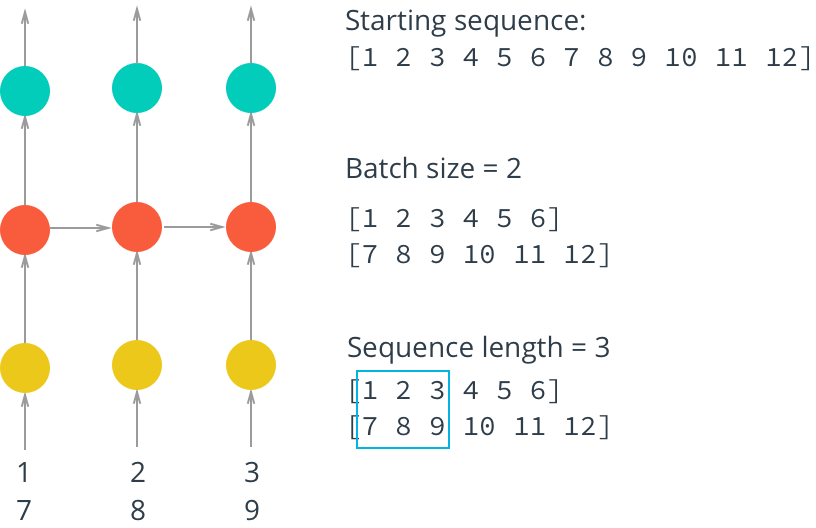




Starting sequence:
[1 2 3 4 5 6 7 8 9 10 11 12 ]

Batchsize = 2
[1 2 3 4 5 6]
[7 8 9 10 11 12]

Sequence length = 3










[[1 2 3] 4 5 6 ]







[[7 8 9] 10 11 12]


In this example, we'll take the encoded characters (passed in as the *arr* parameter) and split them into multiple sequences, given, by *batch_size*. Each of our sequences will be seq_length long.



**Creating Batches**

1. The first thing we need to do is discard some of the text so we only have completely full mini-batches.

Each batch contains *N x M* characters, where *N* is the batch size ( the number of sequences in a batch) and *M* is the seq_length or numbe rof time steps in a sequence. Then, to get the total number of batches.*K*, that we can make from the array *arr*, you divide the length of *arr* by the number of characters per batch. Once you know the number of batches, you can get the total number of characters to keep from *arr*, *NxMxK*.









2. After that, we need to split *arr* into N batches.


You can do this using *arr.reshape(size)* where *size* is a tuple containing the dimensions sizes of the reshaped array. We know we want *N* sequences in a batch, so let's make the size of the first dimension. For the second dimension, you can use *-1* as a placeholder in the size, it'll fill up the array with the appropriate data for you. After this, you should have an array that is *Nx(M*K)*.





3. Now that we have this array, we can iterate through it to get our mini-batches.

The idea is each batch is a *NxM* window on the *Nx(M*K)* array. For each subsequent batch, the window moves over by *seq_length*. We also want to create both the input and target arrays. Remember that the targets are just the inputs shifted over by one character. The way i like to do this window is use *range* to take steps of size *n_steps* from 0 to *arr.shape[1]*, the total numbe rof tokens in each sequence. That way, the integers you get from *range* always point to the start of a batch, and each window is *seq_length* wide.

We'll be going to create batches in the function below.

In [8]:
def get_batches(arr, batch_size, seq_length):
  ''' Create a generator that returns batches of size batch_size x seq_length from arr.

  Arguments
  ---------
  arr: Array yu want to make batches from
  batch_size : Batch size, the number of sequences per batch
  seq_length: Number of encoded chars in a sequence

  '''

  batch_size_total = batch_size * seq_length
  # Total number of batches we can make
  n_batches = len(arr)//batch_size_total

  # Keep only enough characters to make full batches
  arr = arr[:n_batches * batch_size_total]
  # Reshape into batch_size rows
  arr = arr.reshape((batch_size, -1))

  # Iterate through the array, one sequence at a time
  for n in range(0, arr.shape[1], seq_length):
    # the features
    x = arr[:,n:n+seq_length]
    # The targets, shifted by one
    y = np.zeros_like(x)
    try:
      y[:, :-1], y[:, -1] = x[:, 1:], arr[:, n+seq_length]
    except IndexError:
        y[:, :-1], y[:, -1] = x[:, 1:], arr[:,0]
    yield x, y




**Test Your Implementation**


Now we'll make some data sets and we can check out what's going  on as we batch data. Here, as an example, I'm going to use batch size of 8 and 50 sequence steps.




In [9]:
batches = get_batches(encoded, 8, 50)
x, y = next(batches)


In [10]:
# Printing out the first 10 times in a sequence
print('x\n', x[:10, :10])
print('\ny\n', y[:10, :10])


x
 [[19 14 74 10 37 91 96 28  4 10]
 [99 64 82 22 84 19 19 77 85 85]
 [39 99 15 23 84 84 36 46 84 84]
 [62 15 24 84 19 82 40 40 48 40]
 [36 24 40 84 84 15 99 64 87 40]
 [25 84 84 80 61 35 15 23 62 85]
 [84 87 40 64 82 36 82 84 84 38]
 [82 84 84 13 24 40 85 84 84 82]]

y
 [[14 74 10 37 91 96 28  4 10 14]
 [64 82 22 84 19 19 77 85 85 99]
 [99 15 23 84 84 36 46 84 84 24]
 [15 24 84 19 82 40 40 48 40 95]
 [24 40 84 84 15 99 64 87 40 95]
 [84 84 80 61 35 15 23 62 85 42]
 [87 40 64 82 36 82 84 84 38 64]
 [84 84 13 24 40 85 84 84 82 24]]


**Defining the network with PyTorch**


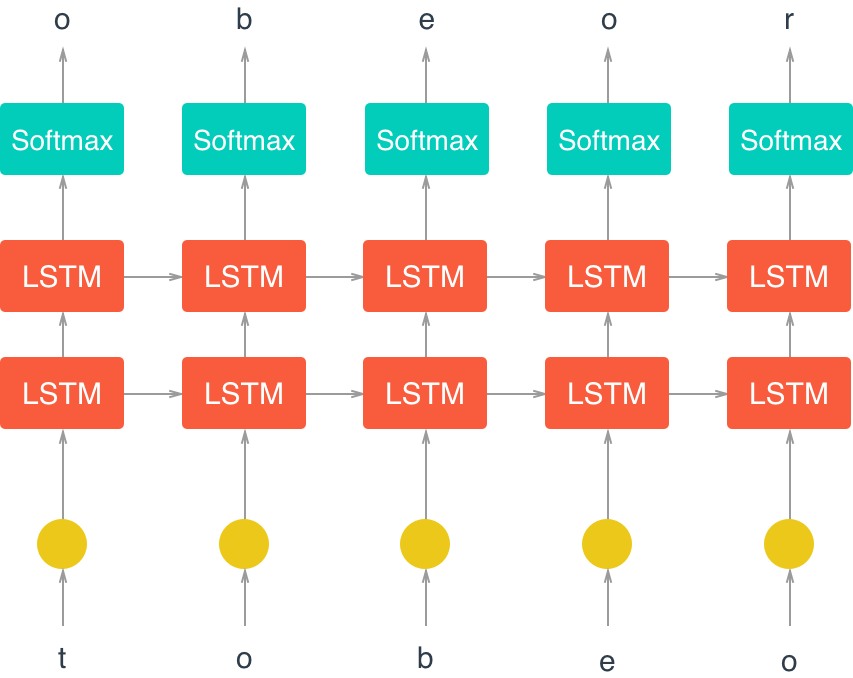






Next, you'll use PyTorch to define the architecture of the network, We start by defining the layers and operations we want. Then, define a method for the forward pass. You've also been given a method for predicting characters.


**Model Structure**

In *__init __* the suggested structure is as follows:

*   Create and store the necessary dictionaries (this has been done for you)
* Define an LSTM layer that makes as params: an input size (the number of characters), a hidden layer size *n_hidden* a number of layers *n_layers*, a dropout probability *drop_prob*, and a batch_first boolean (True, since we are batching)

* Define a dropout layer with*drop_prob*
* Define a fully-connected layer with params: input size *n_hidden* and output size(the number of characters)
* Finally, initialize the weights(again, this has been given)


Note that some parameters have been named and given in the *__init__* function, and we use them and store them by doing something like *self.drop_probe = drop_prob*.




* LSTM Inputs/Outputs
You can create a basic LSTM layer https://pytorch.org/docs/stable/nn.html#lstmas
follows

self.lstm = nn.LSTM(input_size, n_hidden, n_layers, dropout=drop_prob, batch_first=True)

where *input_size* is the number of characters this cell expects to see as sequential input, and *n_hidden* is the number of units in the hidden layers in the cell. and we can add dropout by adding a dropout parameter with a specified probability; this will autimatically add dropout to the inputs or outputs. Finally, in the *forward* function, we can stack up the LSTM cells into layers using *.view*. With this, you pass in a lsit of cells and it will send the outputs of ine cell into the next cell.

We also need to create an initial hidden satte of all zeros. This is done like so *self.init_hidden()*














In [11]:
# Check if GPU is available
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
  print('Training on GPU!')
else:
  print('No GPU available, training on CPU; consider making n_epochs very small.')

No GPU available, training on CPU; consider making n_epochs very small.


In [12]:
import torch.nn as nn

class charRNN(nn.Module):
    def __init__(self, tokens, n_hidden=256, n_layers=2, drop_prob=0.5, lr=0.001):
        super(charRNN, self).__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.lr = lr

        # Creating character dictionaries
        self.chars = tokens
        self.int2char = dict(enumerate(self.chars))
        self.char2int = {ch: ii for ii, ch in self.int2char.items()}

        # Define the LSTM layer
        self.lstm = nn.LSTM(len(self.chars), n_hidden, n_layers, dropout=drop_prob, batch_first=True)

        # Define a dropout layer
        self.dropout = nn.Dropout(drop_prob)

        # Define the final, fully-connected output layer
        self.fc = nn.Linear(n_hidden, len(self.chars))

    def forward(self, x, hidden):
        # Get the outputs and the new hidden state from the LSTM
        r_output, hidden = self.lstm(x, hidden)

        # Pass through a dropout layer
        out = self.dropout(r_output)

        # Stack up LSTM outputs using view
        out = out.contiguous().view(-1, self.n_hidden)

        # Put x through the fully-connected layer
        out = self.fc(out)

        # Return the final output and the hidden state
        return out, hidden

    def init_hidden(self, batch_size):
        # Initialize hidden state
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cpu(),
                  weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cpu())
        return hidden


**Time to train**


The train function gives us the ability to set the numbe rof epochs, the learning rate, and other parameters.

Below we're using an Adam Optimizer and cross entropy loss since we are looking at character class scores as output. We calculate the loss and perform backpropagation , as usual!

A couple of details about training:

*   Within the batch loop, we detach the hidden state from its history; this time setting it equal to new *tuple* variable because an LSTM has a hidden state that is a tuple of the hidden and cell states.

* We use *clip_grad_norm_* to help prevent exploiding gradients.


In [13]:

def train(net, data, epochs=10, batch_size=10, seq_length=50, lr=0.001, clips=5, val_frac=0.1, print_every=10):
    ''' Training a network

    Arguments
    ---------

    net : CharRNN network
    data : text data to train the network
    epochs : Number of epochs to train
    batch_size : Number of mini-sequences per mini-batch, aka batch size
    seq_length : Number of character steps per mini-batch
    lr : learning rate
    clip : gradient clipping
    val_frac : Fraction of data to hold out for validation
    print_every : Number of steps for printing training and validation loss
    '''

    net.train()
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Create training and validation data
    val_idx = int(len(data) * (1 - val_frac))
    data, val_data = data[:val_idx], data[val_idx:]

    if train_on_gpu:
        net.cuda()

    counter = 0
    n_chars = len(net.chars)

    for e in range(epochs):
        # Initialize hidden state
        h = net.init_hidden(batch_size)

        for x, y in get_batches(data, batch_size, seq_length):
            counter += 1

            # One-hot encode our data and make them Torch Tensors
            x = one_hot_encode(x, n_chars)
            inputs, targets = torch.from_numpy(x), torch.from_numpy(y)

            if train_on_gpu:
                inputs, targets = inputs.cuda(), targets.cuda()

            # Creating new variables for the hidden state, otherwise
            # We'd backprop through the entire training history
            h = tuple([each.data for each in h])

            # Zero accumulated gradients
            net.zero_grad()

            # Get the output from the model
            output, h = net(inputs, h)

            # Calculate the loss and perform backprop
            loss = criterion(output, targets.view(batch_size * seq_length).long())
            loss.backward()

            # 'clip_grad_norm' helps prevent the exploding gradient problem in RNNs / LSTMs
            nn.utils.clip_grad_norm_(net.parameters(), clips)
            opt.step()

            # Loss stats
            if counter % print_every == 0:
                # Get validation loss
                val_h = net.init_hidden(batch_size)
                val_losses = []
                net.eval()

                for x, y in get_batches(val_data, batch_size, seq_length):
                    # One-hot encode our data and make them torch tensors
                    x = one_hot_encode(x, n_chars)
                    x, y = torch.from_numpy(x), torch.from_numpy(y)

                    # Creating new variables for the hidden state, otherwise
                    # we'd backprop through the entire training history
                    val_h = tuple([each.data for each in val_h])

                    if train_on_gpu:
                        x, y = x.cuda(), y.cuda()

                    output, val_h = net(x, val_h)
                    val_loss = criterion(output, y.view(batch_size * seq_length).long())
                    val_losses.append(val_loss.item())

                net.train() # Reset to train mode after iterating through validation data

                print("Epoch: {}/{}...".format(e + 1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.4f}...".format(loss.item()),
                      "Val Loss: {:.4f}".format(np.mean(val_losses)))


# Instantiating the model

 Now we can actually train the network. First we'll create the network itself, with some givem hyperparameters. Then, define the mini- batches sizes, and start training !

In [14]:
# Define and print the net

n_hidden = 512
n_layers = 2

net = charRNN(chars, n_hidden, n_layers)
print(net)

charRNN(
  (lstm): LSTM(100, 512, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=100, bias=True)
)


In [15]:
batch_size = 128
seq_length = 100
n_epochs = 10 # Start smaller if you are just testing initial behavior

# Train the model
train(net, encoded, epochs=n_epochs, batch_size=batch_size, seq_length=seq_length, lr=0.001, print_every=10)

Epoch: 1/10... Step: 10... Loss: 3.0799... Val Loss: 3.0480
Epoch: 1/10... Step: 20... Loss: 2.9632... Val Loss: 2.9219
Epoch: 1/10... Step: 30... Loss: 2.9171... Val Loss: 2.8905
Epoch: 1/10... Step: 40... Loss: 2.9197... Val Loss: 2.8798
Epoch: 1/10... Step: 50... Loss: 2.8859... Val Loss: 2.8785
Epoch: 1/10... Step: 60... Loss: 2.9056... Val Loss: 2.8768
Epoch: 1/10... Step: 70... Loss: 2.9025... Val Loss: 2.8759
Epoch: 1/10... Step: 80... Loss: 2.9033... Val Loss: 2.8741
Epoch: 1/10... Step: 90... Loss: 2.8829... Val Loss: 2.8709
Epoch: 1/10... Step: 100... Loss: 2.8788... Val Loss: 2.8626
Epoch: 1/10... Step: 110... Loss: 2.8705... Val Loss: 2.8294
Epoch: 1/10... Step: 120... Loss: 2.7864... Val Loss: 2.7538
Epoch: 1/10... Step: 130... Loss: 2.6927... Val Loss: 2.6424
Epoch: 1/10... Step: 140... Loss: 2.6050... Val Loss: 2.5524
Epoch: 1/10... Step: 150... Loss: 2.5229... Val Loss: 2.4593
Epoch: 1/10... Step: 160... Loss: 2.5573... Val Loss: 2.4049
Epoch: 1/10... Step: 170... Loss:

**Getting the best model**


To set your hyperparameters to get the best performance, you'll want to watch the training and validation losses. If your training loss is much lower than the validation loss, you're overfitting. Increase regularization (more dropout) or use a smaller network. If the training and validation losses are close, you're *underfitting* so you can increase the size of the network.



**Hyperparameters**


Here are the hyperparameters for the network.

In defining the model:

*  *n_hidden_* - The number of units in the hidden layers.

*   *n_layers* - Number of hidden LSTM layers to use.


We assume that dropout probability and learning rate will be kept at the default, in this example.

And in training:



*   *batch_size* - Number of sequences running through the network in one pass.

*  *seq_length* - Number of characters in the sequence the network is trained on.Larger is better typically, the network will learn more long range dependencies.But it takes longer to train. 100 is typically a good number here.

* *lr*- Learning rate for training.








**Tips and Tricks**


**Monitoring Validation Loss vs. Training Loss**






If you're somewhat new to Machine Learning or Neural Networks it can take a bit of expertise to get good models. The most important quantity to keep track of is the difference between your training loss (printed during training) and the validation loss (printed once in a while when the RNN is run on the validation data (by default every 1000 iterations)). In particular:









* If your training loss is much lower than validation loss then this means the network might be *overfitting*. Solutions to this are to decrease your network size, or to increase dropout. For example you could try dropout of 0.5 and so on.








* If your training/validation loss are about equal then your model is *underfitting*. Increase the size of your model (either number of layers or the raw number of neurons per layer)










**Approximate number of parameters**






The two most important parameters that control the model are *n_hidden* and *n_layers*. I would advise that you always use num_layers of either 2/3. The *n_hidden* can be adjusted based on how much data you have. The two important quantities to keep track of here are:



* The number of parameters in your model. This is printed when you start training.





* The size of your dataset. 1MB file is approximately 1 million characters.






These two should be about the same order of magnitude. It's a little tricky to tell. Here are some examples:








* I have a 100MB dataset and I'm using the default parameter settings (which currently print 150K parameters). My data size is significantly larger (100 mil >> 0.15 mil), so I expect to heavily underfit. I am thinking I can comfortably afford to make *n_hidden* larger.






* I have a 10MB dataset and running a 10 million parameter model. I'm slightly nervous and I'm carefully monitoring my validation loss. If it's larger than my training loss then I may want to try to increase dropout a bit and see if that heps the validation loss.









# Best models strategy








The winning strategy to obtaining very good models (if you have the compute time) is to always err on making the network larger (as large as you're willing to wait for it to compute) and then try different dropout values (between 0,1). Whatever model has the best validation performance (the loss, written in the checkpoint filename, low is good) is the one you should use in the end.






It is very common in deep learning to run many different models with many different hyperparameter settings, and in the end take whatever checkpoint gave the best validation performance.










By the way, the size of your training and validation splits are also parameters. Make sure you have a decent amount of data in your validation set or otherwise the validation performance will be noisy and not very informative.







# Checkpoint





After training, we'll save the model so we can load it again later if we need too. Here I'm saving the parameters needed to create the same architecture, the hidden layer hyperparameters and the text characters.




In [16]:
# Change the name, for saving multiple files
model_name = 'rnn_20_epoch.net'

checkpoint = {'n_hidden': net.n_hidden,
              'n-layers': net.n_layers,
              'state_dict': net.state_dict(),
              'tokens': net.chars}

with open(model_name, 'wb') as f:
  torch.save(checkpoint, f)



# Making Predictions


Now that the model is trained. we'll want to sample from it and make predictions about next characters! To sample, we pass in a character and have the network predict the next character. Then we take that character, pass it back in, and  get another predicted character just keep doing this and you'll generate a bunch of text!




# A  note on the *predict* function

The output of our RNN is from a fully-connected layer and it outputs a *distribution of next-character scores*.


---> To actually get the next character, we apply a softmax function, which gives use a probability distribution that we can then sample to predict the next character.


# Top K sampling

Our predictions come from a categorical probability distribution over all the possible characters. We can make the sample text and make it reasonable to handle (with less variables) by only giving us completely absurd characters while allowing it to introduce some noise and randomness into the sampled text. Read more about
https://pytorch.org/docs/stable/torch.html#torch.topk









In [55]:
def predict(net, char, h=None, top_k=None, prime='father'):
  if prime is not None:
    # If prime is provided, use it as the initial input sequence
    for ch in prime:
      char, h = predict(net, ch, h, top_k=top_k, prime=None)  # Recursive call without prime
    ''' Given a character, predict the next character.
    Returns the predicted character and the hidden state.
    '''

    # tensor inputs
    x = np.array([[net.char2int[char]]])
    y = one_hot_encode(x, len(net.chars))
    inputs = torch.from_numpy(x)

    if train_on_gpu:
        inputs = inputs.cuda()

    # Detach hidden state from history
    h = tuple([each.data for each in h])

    # Get the output of the model
    out, h = net(inputs, h)

    # Get the character probabilities
    p = F.softmax(out, dim=1).data
    if train_on_gpu:
        p = p.cpu()  # move to cpu

    # get top characters
    if top_k is None:
        top_ch = np.arange(len(net.chars))
    else:
      p, top_ch = p.top(top_k)
      top_ch = top_ch.numpy().squeeze()

    # Select the likely next character with some element of randomness
    p = p.numpy().squeeze()
    char = np.random.choice(top_ch, p=p/p.sum())

    # Return the encoded value of the predicted char and the hidden state

    return net.int2char[char], h


In [58]:
print(predict(net, 1000, prime=None, top_k=5))

None


In [53]:
def sample(net, size, prime='The', top_k=None):
    if train_on_gpu:
        net.cuda()
    else:
        net.cpu()

    net.eval()  # eval mode

    # First off, run through the prime characters
    chars = [ch for ch in prime]
    h = net.init_hidden(1)
    for ch in prime:
        char, h = predict(net, ch, h, top_k=top_k)

    chars.append(char)

    # Now pass in the previous character and get a new one
    for _ in range(size):
        char, h = predict(net, chars[-1], h, top_k=top_k)
        chars.append(char)

    return ''.join(chars)


# Loading a checkpoint

In [ ]:
# Here we have loaded in a model that trained over 20 epochs 'rnn_20_epoch.net'

with open('rnn_20_epoch.net', 'rb') as f:
  checkpoint = torch.load(f)

loaded = charRNN(checkpoint['tokens'], n_hidden=checkpoint['n_hidden'], n_layers=checkpoint['n_layers'])
loaded.load_state_dict(checkpoint['state_dict'])


try:
    n_layers = checkpoint['n_layers']
except KeyError:
    # Handle the missing key error here, either by setting a default value or raising a custom exception
    n_layers = DEFAULT_VALUE  # Set a default value


In [ ]:
# Sample using a loaded model
print(sample(loaded, 2000, top_k=5, prime="father  of  Russian  realism"))